In [20]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# Generate synthetic dataset
def generate_synthetic_data(num_samples=3000):
    np.random.seed(42)
    
    # Generate date range
    dates = pd.date_range(start="2020-01-01", periods=num_samples, freq='D')
    
    # Generate categorical features
    markets = ["Market A", "Market B", "Market C"]
    counties = ["County X", "County Y", "County Z"]
    commodities = ["Tomato"]
    
    # Generate numerical features
    wholesale_prices = np.random.uniform(20, 100, num_samples)  # Random wholesale prices
    retail_prices = wholesale_prices + np.random.uniform(5, 20, num_samples)  # Retail price > wholesale
    temperature = np.random.uniform(15, 35, num_samples)  # Random temperature
    inflation = np.random.uniform(2, 10, num_samples)  # Random inflation rates
    
    data = {
        "Date": dates,
        "Market": np.random.choice(markets, num_samples),
        "County": np.random.choice(counties, num_samples),
        "Commodity": np.random.choice(commodities, num_samples),
        "Wholesale": wholesale_prices,
        "Retail": retail_prices,
        "Temperature": temperature,
        "Inflation": inflation,
    }
    
    df = pd.DataFrame(data)
    
    # Feature Engineering: Extract seasonality features
    df["Month"] = df["Date"].dt.month
    df["DayOfYear"] = df["Date"].dt.dayofyear
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week
    
    return df


In [22]:
# Load dataset
df = generate_synthetic_data(3000)


In [23]:
# Display initial data overview
print(df.head())
print(df.isnull().sum())

        Date    Market    County Commodity  Wholesale      Retail  \
0 2020-01-01  Market B  County Z    Tomato  49.963210   65.053754   
1 2020-01-02  Market C  County X    Tomato  96.057145  113.007365   
2 2020-01-03  Market C  County X    Tomato  78.559515   87.316534   
3 2020-01-04  Market A  County Z    Tomato  67.892679   82.265790   
4 2020-01-05  Market A  County Y    Tomato  32.481491   46.057681   

   Temperature  Inflation  Month  DayOfYear  WeekOfYear  
0    27.965139   9.308624      1          1           1  
1    18.447727   6.202884      1          2           1  
2    32.447891   7.799282      1          3           1  
3    27.262325   5.488386      1          4           1  
4    18.144078   7.040277      1          5           1  
Date           0
Market         0
County         0
Commodity      0
Wholesale      0
Retail         0
Temperature    0
Inflation      0
Month          0
DayOfYear      0
WeekOfYear     0
dtype: int64


In [24]:
# One-hot encoding for categorical features
def one_hot_encoding(df, columns):
    """Perform one-hot encoding for categorical features."""
    valid_columns = [col for col in columns if col in df.columns]
    if not valid_columns:
        raise ValueError("None of the specified columns exist in the dataframe.")
    one_hot_encoder = ce.OneHotEncoder(cols=valid_columns, return_df=True, use_cat_names=True)
    return one_hot_encoder.fit_transform(df)

In [25]:
# Encode categorical variables
categorical_columns = ["Market", "County", "Commodity"]
df = one_hot_encoding(df, categorical_columns)


In [26]:
# Define features and target
features_to_drop = ["Retail", "Wholesale", "Date"]
X = df.drop(columns=[col for col in features_to_drop if col in df.columns])
Y = df["Retail"] if "Retail" in df.columns else df.get("Wholesale")


In [27]:
# Ensure target variable exists
if Y is None:
    raise ValueError("Target variable not found in the dataset.")

In [28]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=27)

In [29]:
# Initialize PyCaret setup
train, test = train_test_split(df, test_size=0.25, random_state=27)
target_col = "Retail" if "Retail" in df.columns else "Wholesale"
experiment = setup(data=train, target=target_col, imputation_type='iterative')

,Description,Value
0,Session id,1495
1,Target,Retail
2,Target type,Regression
3,Original data shape,"(2250, 15)"
4,Transformed data shape,"(2250, 17)"
5,Transformed train set shape,"(1575, 17)"
6,Transformed test set shape,"(675, 17)"
7,Numeric features,13
8,Date features,1
9,Preprocess,True


In [30]:
# Compare models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,3.7549,18.6953,4.3218,0.9677,0.0709,0.0590,0.0360
lasso,Lasso Regression,3.7558,18.7470,4.3278,0.9676,0.0710,0.0591,0.0330
en,Elastic Net,3.7578,18.7605,4.3293,0.9676,0.0710,0.0591,0.0360
llar,Lasso Least Angle Regression,3.7558,18.7470,4.3278,0.9676,0.0710,0.0591,0.0330
lr,Linear Regression,3.7808,18.9417,4.3502,0.9673,0.0715,0.0595,0.0560
ridge,Ridge Regression,3.7805,18.9375,4.3497,0.9673,0.0714,0.0595,0.0320
lar,Least Angle Regression,3.7808,18.9417,4.3502,0.9673,0.0714,0.0595,0.0350
br,Bayesian Ridge,3.7773,18.9061,4.3462,0.9673,0.0713,0.0594,0.0330
huber,Huber Regressor,3.7876,19.0343,4.3609,0.9671,0.0714,0.0595,0.0610
ada,AdaBoost Regressor,3.7935,19.3177,4.3938,0.9666,0.0720,0.0597,0.2410


In [31]:
# Train a RandomForestRegressor model
random_reg = RandomForestRegressor(n_estimators=100, random_state=0)
random_reg.fit(X_train, Y_train)

RandomForestRegressor(random_state=0)

In [32]:
# Make predictions
Y_pred = random_reg.predict(X_test)

In [33]:
# Evaluate model performance
mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

MSE: 575.3231171761289
MAE: 20.187762899626694
R² Score: -0.08288927071891816


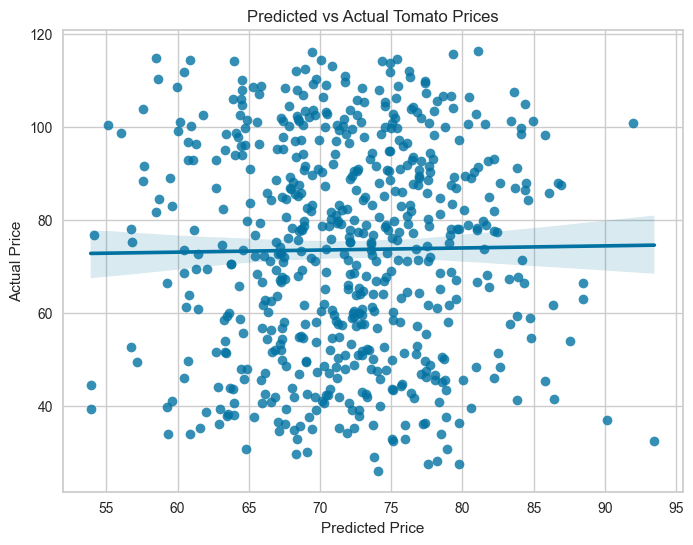

In [34]:
# Visualize predictions
plt.figure(figsize=(8, 6))
sns.regplot(x=Y_pred, y=Y_test)
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Predicted vs Actual Tomato Prices")
plt.show()